In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import seaborn
import os

In [2]:
def compute_distance(gps_coordinate1, gps_coordinate2):
    ## gps_coordinate1 = [latitude, longitude]
    R = 6371e3;
    latitude1 = math.radians(gps_coordinate1[0])
    latitude2 = math.radians(gps_coordinate2[0])
    longitude1= gps_coordinate1[1]
    longitude2= gps_coordinate2[1]
    
    lat_diff = latitude2 - latitude1
    long_diff= math.radians(longitude2- longitude1)
    
    a = math.pow(math.sin(lat_diff/2), 2) + \
        math.cos(latitude1) * math.cos(latitude2) * \
        math.pow(math.sin(long_diff/2), 2)
    
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    distance = R * c
    
    return distance

In [3]:
def compute_distance2(gps_coordinate1, gps_coordinate2):
    ## gps_coordinate1 = [latitude, longitude]

    latitude1 = gps_coordinate1[0]
    latitude2 = gps_coordinate2[0]
    longitude1= gps_coordinate1[1]
    longitude2= gps_coordinate2[1]
    
    lat_diff_square = math.pow(latitude2-latitude1,2)
    long_diff_square = math.pow(longitude2-longitude1,2)
    
    return math.sqrt(lat_diff_square + long_diff_square)

./LG_DATA/January_GoMentum/failure3/2020-01-28-14-40-41


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2862: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  exec(code_obj, self.user_global_ns, self.user_ns)


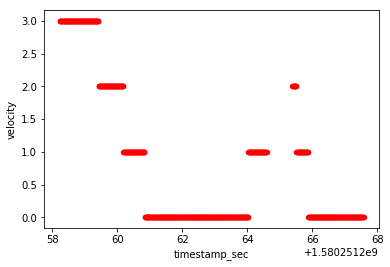

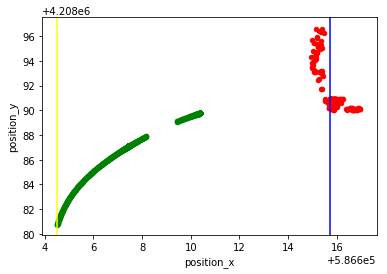

min Time-to-Collision:  4.8822562840499755


In [4]:
scenario_path = "./LG_DATA/January_GoMentum/failure3/"
ped_table_list = []
ego_table_list = []

i = 0

for directory in sorted([d for d in os.listdir(scenario_path) if not d.endswith('.DS_Store')]):
    if i >= 1:
        break
    i += 1
    
    for file in sorted([f for f in os.listdir(os.path.join(scenario_path, directory)) if f.endswith('.csv')]):
        directory_path = os.path.join(scenario_path, directory)
        if("pedestrian" in file.split('-')[1]):
            path_to_file = os.path.join(directory_path, file)
            ped_table_list.append(pd.read_csv(path_to_file, sep=';'))
        else:
            path_to_file = os.path.join(directory_path, file)
            ego_table_list.append(pd.read_csv(path_to_file, sep=';'))

    # combine different pedestrian .csvs into one dataframe
    pedestrian_table = pd.concat(ped_table_list, ignore_index=True)
    ego_table        = pd.concat(ego_table_list, ignore_index=True)
    pd.set_option('display.float_format', lambda x: '%.3f' % x)     

    time = []
    indices = []
    count = -1
    for index, row in pedestrian_table.iterrows():
        count +=1
        if row['position_x'] > 586615.7 and row['position_x'] < 586616 and row['position_y'] < 4208090.5:
            time.append(row['timestamp_sec'])
            indices.append(count)
    
    pedestrian_start_time = pedestrian_table['timestamp_sec'][0]
    pedestrian_crossed_time = min(time)
    pedestrian_crossed_index = min(indices)
    
    print(os.path.join(scenario_path, directory))
    
#     pedestrian_table.plot(kind='scatter', x='position_x', y='position_y', color='green')
#     plt.axvline(pedestrian_table['position_x'][pedestrian_crossed_index])
#     plt.show()
    
    ego_parsed_table = ego_table[(ego_table.timestamp_sec >= pedestrian_start_time) & (ego_table.timestamp_sec <= pedestrian_crossed_time)]
    
    ego_parsed_table['velocity'] = 0
    ego_parsed_table['velocity'].apply(pd.to_numeric)
    
    for index, row in ego_parsed_table.iterrows():
        ego_parsed_table['velocity'][index] = math.sqrt( float(ego_parsed_table['linear_vel_x'][index])*float(ego_parsed_table['linear_vel_x'][index]) 
                                                        + float(ego_parsed_table['linear_vel_y'][index])*float(ego_parsed_table['linear_vel_y'][index]))

    ego_parsed_table.plot(kind='scatter', x = 'timestamp_sec', y = 'velocity', color='red')
    plt.show()
    
    min_x = 0
    min_TTC = 1000
    TTC_list = []
    for index, row in pedestrian_table.iterrows():
        table = ego_parsed_table.loc[(ego_parsed_table['timestamp_sec'] >= pedestrian_start_time) &
                                     (ego_parsed_table['timestamp_sec'] <=pedestrian_start_time+0.2)]
        ego_velocity = table.iloc[0]['velocity']
        distance = compute_distance2([row['position_x'], row['position_y']],[table.iloc[0]['position_x'], 
                                                                           table.iloc[0]['position_y']])
        
        TTC = float(distance / ego_velocity)
        TTC_list.append(TTC)
        if TTC < min_TTC:
            min_TTC = TTC
            min_x   = table.iloc[0]['position_x']
    
    ax = ego_parsed_table.plot(kind='scatter', x ='position_x', y = 'position_y', color='green')
    pedestrian_table.plot(kind='scatter', x='position_x', y='position_y', color='red',ax =ax)
    plt.axvline(pedestrian_table['position_x'][pedestrian_crossed_index], color = 'blue')
    plt.axvline(min_x, color ='yellow')
    plt.show()
        
    print("min Time-to-Collision: ", min_TTC)
    
        
    




5.361721185606174


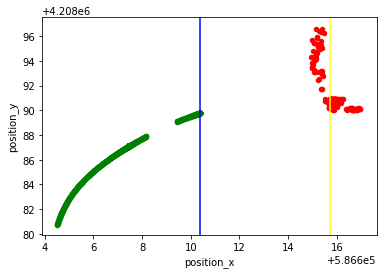

In [13]:
last = ego_parsed_table.iloc[-1]

x = last['position_x']
y = last['position_y']
time = last['timestamp_sec']

t = pedestrian_table.loc[(pedestrian_table['timestamp_sec'] >= time - 0.1) &
                                     (pedestrian_table['timestamp_sec'] <= time + 0.1)]

ped = t.iloc[0]
p_x = ped['position_x']
p_y = ped['position_y']
p_time = ped['timestamp_sec']

print(compute_distance2([x,y],[p_x, p_y]))
ax = ego_parsed_table.plot(kind='scatter', x ='position_x', y = 'position_y', color='green')
pedestrian_table.plot(kind='scatter', x='position_x', y='position_y', color='red',ax =ax)
plt.axvline(x, color = 'blue')
plt.axvline(p_x, color ='yellow')
plt.show()

In [61]:
distance

1656866.9355154887